![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# TFM - Análisis Exploratorio de Datos (EDA)

### Descripción del dataset y su contexto:
El presente dataset contiene información detallada sobre propiedades en venta, incluyendo su precio, ubicación, dimensiones y diversas características adicionales. Cada registro representa un anuncio de un inmueble y cuenta con datos sobre su barrio, distrito, consumo energético y otros atributos socioeconómicos.

El objetivo de este estudio es analizar el conjunto de datos para extraer insights que permitan comprender mejor el mercado inmobiliario y detectar patrones que puedan ser útiles para la toma de decisiones.

### Objetivos del EDA:
1. Comprender la estructura del dataset: Identificar el número de registros y columnas, los tipos de datos y la presencia de valores nulos o inconsistencias.
2. Analizar la distribución de las variables: Explorar la variabilidad en precios, metros cuadrados, ubicaciones y otras características relevantes.
3. Detectar relaciones y correlaciones: Investigar posibles asociaciones entre las variables y su impacto en el precio de los inmuebles.
4. Identificar valores atípicos: Detectar posibles errores o anomalías en los datos que puedan afectar el análisis.
5. Generar insights clave: Extraer información relevante para futuros estudios o modelos de predicción del valor de los inmuebles.

Este análisis servirá como base para entender mejor la dinámica del mercado inmobiliario y podrá ser de utilidad para compradores, vendedores, inversionistas y analistas del sector.

# 1. Librerías y configuración

In [71]:
# !pip install jupyter-collaboration

In [72]:
# Principales
import pandas as pd
import numpy as np

# Modificaciones 
import re
from unidecode import unidecode
import unicodedata
import datetime
import os
import math

# visuzalizaciones
import seaborn as sns
import missingno as msno
import matplotlib as plt 
import plotly.express as px 
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import missingno as msno

In [73]:
pd.set_option('display.max_info_columns',110 )
# pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',80)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
# Ajustar la configuración para mostrar más filas 
# pd.set_option('display.max_rows', 500)

# Inicializar la lista to replace
to_replace=['Null','Nan','nan','NULL',None]

# 2. Funciones

In [74]:
#Funcion que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    boolean_columns=[col for col in df.columns if set(df[col].unique()) <= {0, 1}]
    numeric_cols=int_columns + float_columns 
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()
     
    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas 
    all_columns = set(df.columns) 
    # # Columnas de otros tipos 
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))

    # Cuento el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    #print("Número de columnas de tipo entero:", num_int_columns)
    #print("Columnas de tipo entero:", int_columns)
    #print("Número de columnas de tipo float:", num_float_columns)
    #print("Columnas de tipo float:", float_columns)
    #print("Número de columnas de tipo object:", num_object_columns)
    #print("Columnas de tipo object:", object_columns)
    #print("Número de columnas de tipo category:", num_category_columns)
    #print("Columnas de tipo category:", category_columns)
    #print("Número de columnas de otros tipos:", num_other_columns)
    #print("Columnas de otros tipos:", other_columns)
    return boolean_columns,numeric_cols,cat_columns,object_columns,other_columns

In [75]:
def reduce_mem_usage(df, turn_cat=False, silence=True):
    """Itera sobre todo el dataset convirtiendo cada columna en el tipo más adecuado para ahorrar memoria
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe que se quiere reducir
    turn_cat : bool, optional
        Transformación de las columnas objeto o string a category, by default False
    Returns
    -------
    pd.DataFrame
        Dataframe optimizado
    """
  
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.api.types.is_numeric_dtype(df[col]):
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        if turn_cat and col_type == object:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if not silence:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [76]:
def graficobarrascategoricas(df, colname):
    """Plots the barplot of a categorical variable with top 10 categories and groups the rest as 'Otros'. 

    Parameters:
    df (DataFrame): The DataFrame containing the data
    colname (str): Categorical variable's name

    Returns:
    None
    """ 
    # Obtener las frecuencias de las categorías
    value_counts = df[colname].value_counts()

    # Seleccionar las 10 categorías más frecuentes
    top_10 = value_counts.head(10)

    # Agrupar el resto en 'Otros'
    other_count = value_counts.tail(len(value_counts) - 10).sum()  # Sumar las frecuencias de las categorías restantes
    if other_count > 0:  # Solo agrupar si hay categorías para agrupar
        otros_series = pd.Series({'Otros': other_count})
        top_10 = pd.concat([top_10, otros_series])  # Usamos pd.concat() en lugar de append

    # Crear el gráfico de barras
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(f"Frecuencia de {colname}", fontsize=16)
    top_10.plot(kind='bar')

    # Mostrar el gráfico
    plt.xlabel(colname)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    plt.show()

In [77]:
def plot_histogram_by_target(df, input_name, target_name, normalize = False):
    """Plots the histogram and boxplot of a numerical variable by target

    Parameters:
    input_name (str): Numeric variable's name
    target_name (str): Target variable's name

    Returns:
    None
    """
    fig = plt.figure(figsize=(15, 6))  # Ajustar el tamaño de la figura según sea necesario
    fig.suptitle(input_name, fontsize=16)

 
    ax1 = fig.add_subplot(121)
    sns.histplot(data=df, x=input_name, hue=target_name, alpha=.5, bins=25, ax=ax1, stat = 'density', common_norm = not normalize)
    
    ax2 = fig.add_subplot(122)
    sns.boxplot(data=df, x=target_name, y=input_name, ax=ax2)

    plt.tight_layout()
      # Asegurar que el título de la figura no se superponga
    plt.subplots_adjust(top=0.85)

In [78]:

def plot_barplot_by_target(df, input_name, target_name, stacked=False):
    """
    Grafica un gráfico de barras para una variable categórica en función de una variable objetivo.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos.
    input_name : str
        Nombre de la columna categórica a analizar.
    target_name : str
        Nombre de la columna objetivo (target).
    stacked : bool, opcional, default=False
        Si se debe apilar el gráfico de barras.
    """
    # Crear una tabla de contingencia
    crosstab = pd.crosstab(df[input_name], df[target_name])
    
    # Crear un gráfico de barras apiladas usando Plotly
    fig = px.bar(crosstab, 
                 barmode='stack',  # Esto apila las barras
                # color=crosstab.columns,  # Colores por las columnas
                 title=f'Distribución de {input_name} por {target_name}')
    
    # Mostrar el gráfico
    fig.update_layout(xaxis_title=input_name, 
                      yaxis_title='Frecuencia', 
                      xaxis_tickangle=-45)
    
    fig.show()

# 3. Carga de datos

In [79]:
dfEDA= pd.read_csv('./data/pisosEDA.csv',index_col=False)

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_22266/2743511520.py:1: DtypeWarning:

Columns (19,50) have mixed types. Specify dtype option on import or set low_memory=False.



In [80]:
print(f"El DataFrame dfEDA tiene {dfEDA.shape[0]} filas y {dfEDA.shape[1]} columnas.")

El DataFrame dfEDA tiene 10421 filas y 103 columnas.


In [81]:
dfEDA.columns

Index(['Unnamed: 0', 'url', 'precio', 'descuento', 'm2_constr', 'distrito',
       'cod_distrito', 'barrio', 'cod_barrio', 'consumoce_ano',
       ...
       'hog_con_6', 'hog_con_7', 'hog_con_8', 'hog_con_9', 'hog_con_10',
       'hog_con_11', 'hog_con_12', 'hog_con_13', 'hog_con_14',
       'hog_con_15 y más'],
      dtype='object', length=103)

In [82]:
dfEDA.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,10421.00,NaN,NaN,NaN,5210.00,3008.43,0.00,2605.00,5210.00,7815.00,10420.00
url,10421,10421,https://www.pisosmadrid.com.es/propiedad/4086544-piso-en-venta-en-madrid,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precio,10421.00,NaN,NaN,NaN,887678.02,1155675.73,25000.00,239900.00,480000.00,1090000.00,19950000.00
descuento,54.00,NaN,NaN,NaN,-7.79,2.99,-23.10,-9.00,-7.25,-5.75,-5.00
m2_constr,10394.00,NaN,NaN,NaN,137.21,148.68,0.00,68.00,98.00,149.00,4574.00
...,...,...,...,...,...,...,...,...,...,...,...
hog_con_11,10421.00,NaN,NaN,NaN,27.38,17.42,3.00,10.00,26.00,36.00,64.00
hog_con_12,10421.00,NaN,NaN,NaN,17.16,11.67,0.00,8.00,14.00,21.00,50.00
hog_con_13,10421.00,NaN,NaN,NaN,9.29,5.23,0.00,4.00,9.00,11.00,22.00
hog_con_14,10421.00,NaN,NaN,NaN,36.96,13.59,7.00,28.00,39.00,48.00,59.00


In [83]:
# Tratar las columnas para quitar espacios si tuvieran y poner el nombre de las columnas en minúsculas
# para tener desde el primer momento siempre el mismo nombre de columnas.
dfEDA.columns = [col.strip().lower() for col in dfEDA.columns]

In [84]:
dfEDA.columns.tolist()

['unnamed: 0',
 'url',
 'precio',
 'descuento',
 'm2_constr',
 'distrito',
 'cod_distrito',
 'barrio',
 'cod_barrio',
 'consumoce_ano',
 'letrace',
 'tipologia',
 'estado',
 'amueblado',
 'planta',
 'dormitorios',
 'banos',
 'garaje',
 'trastero',
 'ascensor',
 'porteria',
 'ano_construccion',
 'jardin',
 'cancha_tenis',
 'carpinteria_exterior_doble_vidrio/pvc',
 'carpinteria_exterior_doble_vidrio/madera',
 'carpinteria_exterior_doble_vidrio/metal',
 'carpinteria_exterior_triple_vidrio/madera',
 'carpinteria_exterior_triple_vidrio/metal',
 'carpinteria_exterior_vidrio/pvc',
 'carpinteria_exterior_vidrio/madera',
 'carpinteria_exterior_vidrio/metal',
 'chimenea',
 'cocina',
 'exterior',
 'interior',
 'interior_y_exterior',
 'tiene_piscina',
 'porton_electrico',
 'puerta_blindada',
 'alarma',
 'videoportero',
 'acceso_discapacidad',
 'certificado_energetico',
 'tiene_jardin',
 'cantidad_visitas',
 'cantidad_armarios',
 'agua_caliente',
 'tipo_suelo',
 'm2_utiles',
 'gastos_comunidad',
 '

In [85]:
# Identificación de tipos de datos
dfEDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10421 entries, 0 to 10420
Data columns (total 103 columns):
 #    Column                                            Non-Null Count  Dtype  
---   ------                                            --------------  -----  
 0    unnamed: 0                                        10421 non-null  int64  
 1    url                                               10421 non-null  object 
 2    precio                                            10421 non-null  float64
 3    descuento                                         54 non-null     float64
 4    m2_constr                                         10394 non-null  float64
 5    distrito                                          10402 non-null  object 
 6    cod_distrito                                      10421 non-null  float64
 7    barrio                                            10163 non-null  object 
 8    cod_barrio                                        10184 non-null  float64
 9    cons

Tipos de datos:
- 74 columnas de tipo float64 (datos numéricos con decimales).
- 1 columna de tipo int64 (datos numéricos enteros).
- 28 columnas de tipo object (datos categóricos o de texto).

Las columnas `ascensor (19)` y `gastos_comunidad (50)` tienen tipos de datos mixtos, lo que podría generar problemas en el análisis.

Identificación de Valores Nulos

Los valores nulos pueden afectar los análisis estadísticos y las visualizaciones. Para detectarlos, revisaremos:
- La cantidad de valores nulos por columna.
- El porcentaje de valores nulos en relación con el total de datos.
- Visualización de los valores nulos para identificar patrones.

In [86]:
# Verificar valores nulos por columna
valores_nulos = dfEDA.isnull().sum()

print("Valores nulos por columna:")
print(valores_nulos[valores_nulos > 0])

Valores nulos por columna:
descuento                                    10367
m2_constr                                       27
distrito                                        19
barrio                                         258
cod_barrio                                     237
consumoce_ano                                 9920
letrace                                       9033
estado                                        4755
amueblado                                     7527
planta                                        4642
dormitorios                                    190
banos                                          304
garaje                                        8366
trastero                                      1696
ascensor                                      2309
porteria                                     10269
ano_construccion                              6940
jardin                                        8234
cancha_tenis                                  7087
carp

In [87]:
# Ver porcentaje de valores nulos
porcentaje_nulos = (dfEDA.isnull().sum() / len(dfEDA)) * 100

print("\nPorcentaje de valores nulos por columna:")
print(porcentaje_nulos[porcentaje_nulos > 0])


Porcentaje de valores nulos por columna:
descuento                                   99.48
m2_constr                                    0.26
distrito                                     0.18
barrio                                       2.48
cod_barrio                                   2.27
consumoce_ano                               95.19
letrace                                     86.68
estado                                      45.63
amueblado                                   72.23
planta                                      44.54
dormitorios                                  1.82
banos                                        2.92
garaje                                      80.28
trastero                                    16.27
ascensor                                    22.16
porteria                                    98.54
ano_construccion                            66.60
jardin                                      79.01
cancha_tenis                                68.01
carpinte

<Axes: >

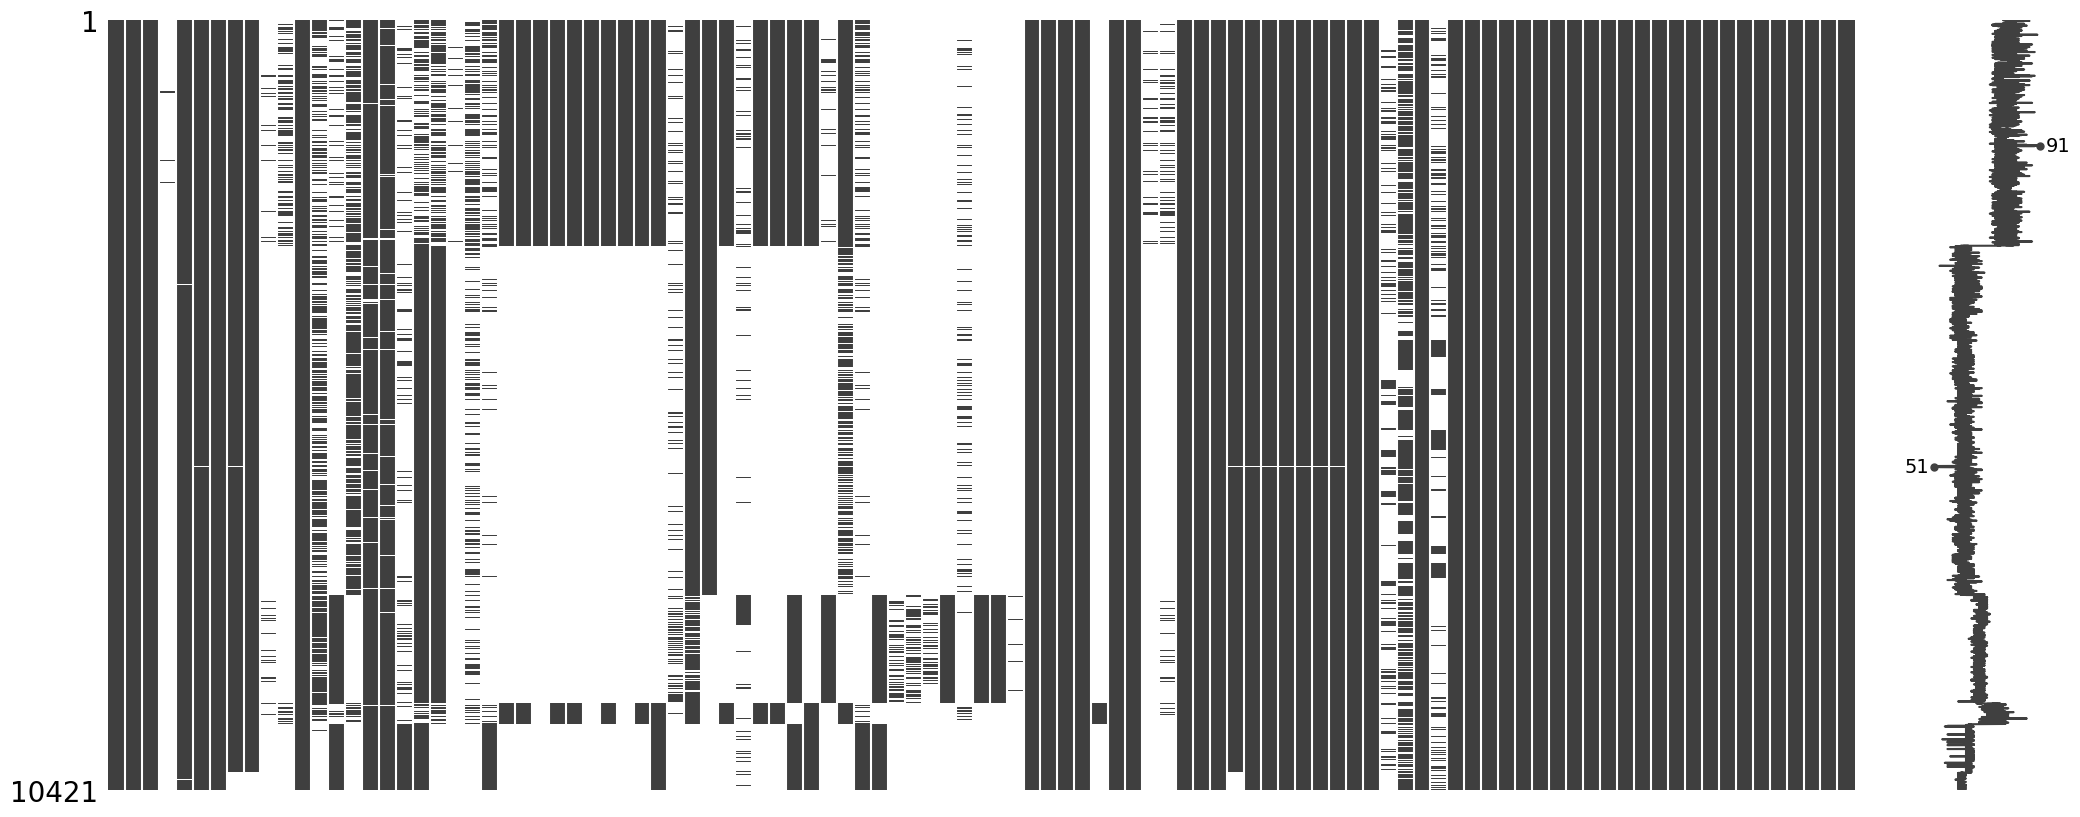

In [88]:
# Visualización de valores nulos con un heatmap
msno.matrix(dfEDA)

In [107]:
import plotly.figure_factory as ff

# Crear una matriz de valores nulos en formato binario (1 = NaN, 0 = No NaN)
df_nulos = dfEDA.isnull().astype(int)

# Crear la visualización interactiva con Plotly
fig = ff.create_annotated_heatmap(
    z=df_nulos.values,
    x=dfEDA.columns.tolist(),
    y=dfEDA.index.tolist(),
    colorscale='blues',
    showscale=True
)

fig.update_layout(
    title="Mapa de Valores Nulos",
    xaxis=dict(title="Columnas", tickangle=-45),
    yaxis=dict(title="Índices"),
    autosize=True
)

fig.show()

KeyboardInterrupt: 

#### 🚩
Explicación de las gráficas

Identificación de Datos Duplicados
- Los registros duplicados pueden distorsionar el análisis y deben ser detectados para evaluar si deben eliminarse.

In [89]:
duplicados = dfEDA.duplicated().sum()

print(f"\nCantidad de registros duplicados: {duplicados}")


Cantidad de registros duplicados: 0


In [90]:
# Mostrar ejemplos de registros duplicados (si existen)
if duplicados > 0:
    print("\nEjemplo de registros duplicados:")
    display(dfEDA[dfEDA.duplicated()].head())

# 4. Exploración de datos

In [91]:
# Distribución de la variable target en porcentaje
dfEDA["precio"].value_counts(normalize = True) 

precio
220000.00    0.01
650000.00    0.01
230000.00    0.01
260000.00    0.01
240000.00    0.01
             ... 
119500.00    0.00
374000.00    0.00
2898000.00   0.00
793000.00    0.00
85900.00     0.00
Name: proportion, Length: 1641, dtype: float64

In [92]:
dfEDA.precio.describe(percentiles=[0.15,0.3,0.45,0.55,0.75,0.9])

count      10421.00
mean      887678.02
std      1155675.73
min        25000.00
15%       185000.00
30%       269000.00
45%       400000.00
50%       480000.00
55%       580000.00
75%      1090000.00
90%      1990000.00
max     19950000.00
Name: precio, dtype: float64

In [93]:
dfEDA.drop_duplicates(keep='first', inplace=True)

In [94]:
# Compruebo que url es unico
dfEDA['url'].nunique() == len(dfEDA)

True

In [95]:
dfEDA["precio"].describe()

count      10421.00
mean      887678.02
std      1155675.73
min        25000.00
25%       239900.00
50%       480000.00
75%      1090000.00
max     19950000.00
Name: precio, dtype: float64

In [96]:
# HISTOGRAMA
fig = px.histogram(dfEDA,x="precio", nbins=100,title='Precio en Euros', labels={'value': 'Precio'})
fig.show()

#### 🚩
Explicación de las gráficas

In [97]:
# Función `columnas_por_tipo` que muestra un resumen de los tipo de columnas que hay en el dataframe
# boolean_columns, numeric_cols, cat_columns, object_columns, other_columns
cols_bool, cols_num, cols_cat, cols_obj, cols_other = columnas_por_tipo(dfEDA)
print("Booleans:", cols_bool)
print("Numéricas:", cols_num)
print("Categóricas:", cols_cat)
print("Objeto:", cols_obj)
print("Otras:", cols_other)

Booleans: ['orientacion_este', 'orientacion_norte', 'orientacion_oeste', 'orientacion_sur']
Numéricas: ['unnamed: 0', 'precio', 'descuento', 'm2_constr', 'cod_distrito', 'cod_barrio', 'dormitorios', 'trastero', 'cancha_tenis', 'carpinteria_exterior_doble_vidrio/pvc', 'carpinteria_exterior_doble_vidrio/madera', 'carpinteria_exterior_doble_vidrio/metal', 'carpinteria_exterior_triple_vidrio/madera', 'carpinteria_exterior_triple_vidrio/metal', 'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/madera', 'carpinteria_exterior_vidrio/metal', 'chimenea', 'exterior', 'interior', 'interior_y_exterior', 'tiene_piscina', 'porton_electrico', 'puerta_blindada', 'alarma', 'videoportero', 'acceso_discapacidad', 'tiene_jardin', 'cantidad_visitas', 'cantidad_armarios', 'm2_utiles', 'zonas_verdes', 'puerta_seguridad', 'orientacion_este', 'orientacion_norte', 'orientacion_oeste', 'orientacion_sur', 'sistema_alarma', 'emisiones_ano', 'codigo_postal', 'num_personas', 'num_personas_hombres', 'nu

# 5. Análisis estadístico inicial

### 5.1 Análisis univariado
El análisis univariado permite estudiar la distribución de cada variable por separado, identificando patrones, valores atípicos y posibles problemas en los datos.

#### 5.1.1 Distribución de variables numéricas
Las variables numéricas se pueden analizar mediante histogramas para observar su distribución y boxplots o gráficos de violín para detectar posibles valores atípicos.

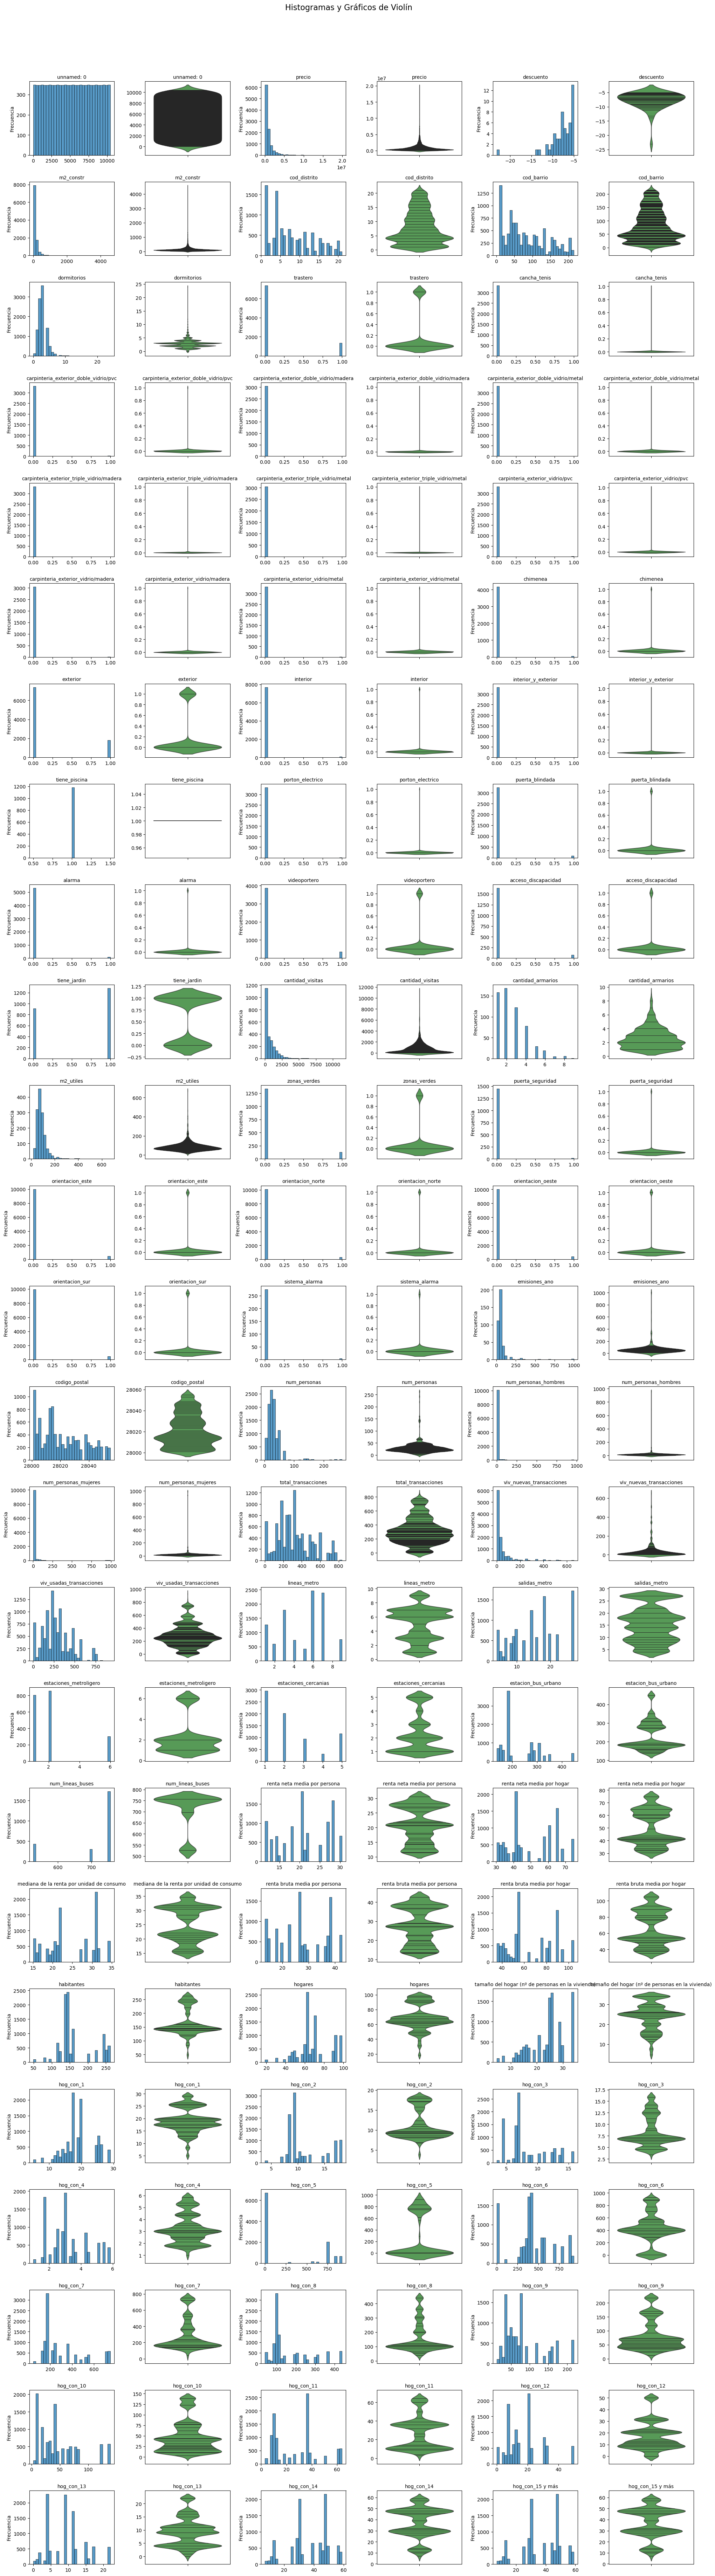

In [98]:
#Gráfico con histogramas y violín

# Parámetros 
var_porfila = 3  # Número de variables por fila
graf_porvariable = 2  # Histograma y violín
tot_var = len(cols_num)

# Calcular el número de filas y columnas
n_cols = var_porfila * graf_porvariable  # Total de columnas por fila
n_rows = math.ceil(tot_var / var_porfila)  # Número de filas necesarias

# Crear subplots dinámicamente
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 3 * n_rows))
fig.suptitle('Histogramas y Gráficos de Violín', fontsize=16)

if n_rows == 1:
    axes = axes.reshape(1, -1)  # Convierte a 2D si hay solo una fila

# Añadir gráficos
for i, col in enumerate(cols_num):
    row = i // var_porfila  # Fila correspondiente
    col_hist = (i % var_porfila) * graf_porvariable  # Columna del histograma
    col_violin = col_hist + 1  # Columna del gráfico de violín

    # Histograma
    sns.histplot(dfEDA[col].dropna(), bins=30, ax=axes[row, col_hist])
    axes[row, col_hist].set_title(f'{col}', fontsize=10)
    axes[row, col_hist].set_xlabel("")
    axes[row, col_hist].set_ylabel("Frecuencia")

    # Gráfico de violín

    sns.violinplot(y=dfEDA[col].dropna(), ax=axes[row, col_violin], inner="stick", color='green', alpha=0.7)

    axes[row, col_violin].set_title(f'{col}', fontsize=10)
    axes[row, col_violin].set_ylabel("")
    axes[row, col_violin].set_xlabel("")

# Ajustar el diseño
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### 🚩
Interpretación de las gráficas.

#### 5.1.2 Distribución de variables categóricas
Para las variables categóricas, los gráficos de barras ayudan a visualizar la frecuencia de cada categoría.

In [99]:
# Gráfico de barras de variables categóricas
for col in cols_cat:
    graficobarrascategoricas(dfEDA,colname=col)

Identificación de valores atípicos
- Los valores atípicos pueden sesgar el análisis, por lo que es importante detectarlos y decidir si eliminarlos o transformarlos.

In [100]:
# Detectar valores atípicos con IQR
Q1 = dfEDA['precio'].quantile(0.25)
Q3 = dfEDA['precio'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar valores atípicos
outliers = dfEDA[(dfEDA['precio'] < limite_inferior) | (dfEDA['precio'] > limite_superior)]
print(f'Cantidad de valores atípicos en precio: {len(outliers)}')

Cantidad de valores atípicos en precio: 835


### 5.2 Análisis bivariado
El análisis bivariado nos permite estudiar la relación entre dos variables, ya sean numéricas o categóricas.

#### 5.2.1 Matriz de correlación y heatmap
La matriz de correlación nos ayuda a identificar relaciones entre variables numéricas.

In [101]:
# Matriz de correlación
correlacion = dfEDA.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

ValueError: could not convert string to float: 'https://www.indomio.es/anuncios/75404850/'

In [68]:
# Distribución de variables numéricas


# Selecciono un subconjunto de variables numericas para hacer el estudio
# cols= ['m2_constr', 'cod_barrio','cod_distrito']
# for c in cols:
#     plot_histogram_by_target(df = dfEDA.sort_values("precio"), input_name = c, target_name = 'precio', normalize = True)

#### 5.2.2 Relaciones entre variables numéricas
Para analizar relaciones entre variables numéricas, utilizamos scatter plots y pairplots.

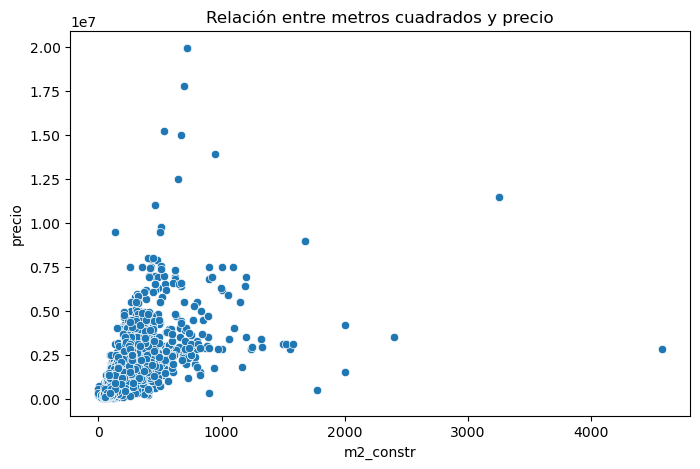

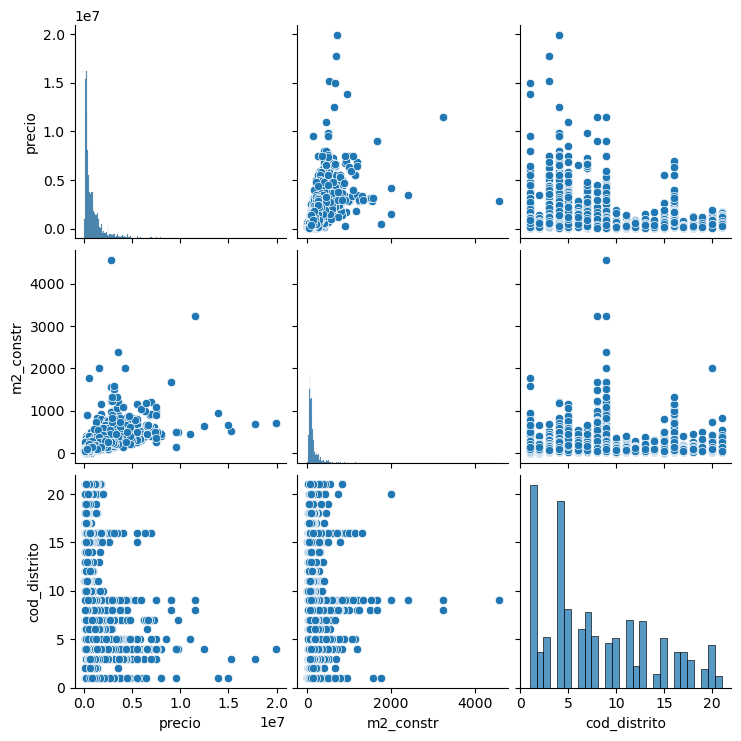

In [102]:
# Scatter plot entre precio y metros cuadrados
plt.figure(figsize=(8,5))
sns.scatterplot(x=dfEDA['m2_constr'], y=dfEDA['precio'])
plt.title('Relación entre metros cuadrados y precio')
plt.show()

# Pairplot de variables numéricas claves
sns.pairplot(dfEDA[['precio', 'm2_constr', 'cod_distrito']])
plt.show()

#### 🚩
Explicación de las gráficas

#### 5.2.3 Análisis de variables categóricas vs numéricas
Podemos analizar la distribución de variables categóricas con boxplots y violin plots. Este análisis nos permite entender mejor las relaciones entre variables y detectar patrones relevantes.

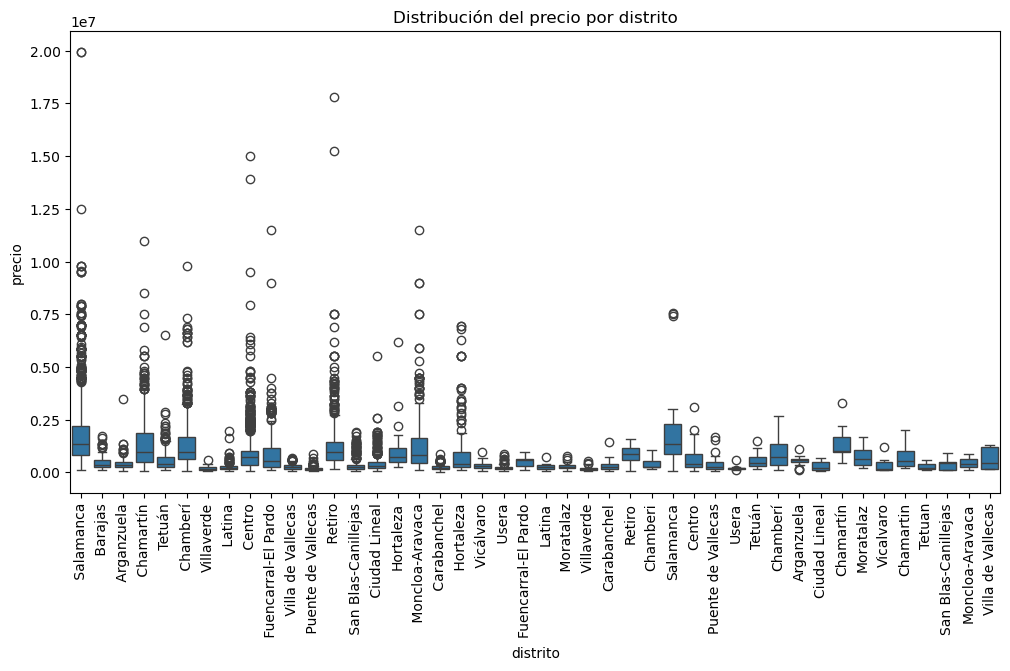

In [103]:
# Boxplot del precio según distrito
plt.figure(figsize=(12,6))
sns.boxplot(x=dfEDA['distrito'], y=dfEDA['precio'])
plt.xticks(rotation=90)
plt.title('Distribución del precio por distrito')
plt.show()

#### 🚩
Explicación de las gráficas

In [69]:
# Distribución de variables categóricas

# Asumiendo que tienes el dataframe dfMMP y las variables categóricas
# for c in cols_cat:
#         plot_barplot_by_target(df=dfEDA, input_name=c, target_name='precio', stacked=True)

# 6. Limpieza de datos

### 6.1 Eliminación de duplicados

In [104]:
# Comprobamos si hay filas duplicadas 
len(dfEDA.drop_duplicates()) / len(dfEDA) 

1.0

### 6.2 Tratamiento de nulos
Dependiendo de la cantidad de valores nulos y duplicados detectados, se pueden tomar las siguientes acciones:
- Eliminar registros con muchos valores nulos si afectan el análisis.
- Imputar valores faltantes
- Eliminar registros duplicados si no aportan valor al análisis.

In [105]:
for col in dfEDA.columns:
    porcentaje_nulos = dfEDA[col].isnull().mean() * 100
    if porcentaje_nulos > 65:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna descuento: 99.48% nulos
Columna consumoce_ano: 95.19% nulos
Columna letrace: 86.68% nulos
Columna amueblado: 72.23% nulos
Columna garaje: 80.28% nulos
Columna porteria: 98.54% nulos
Columna ano_construccion: 66.60% nulos
Columna jardin: 79.01% nulos
Columna cancha_tenis: 68.01% nulos
Columna carpinteria_exterior_doble_vidrio/pvc: 68.01% nulos
Columna carpinteria_exterior_doble_vidrio/madera: 70.68% nulos
Columna carpinteria_exterior_doble_vidrio/metal: 68.01% nulos
Columna carpinteria_exterior_triple_vidrio/madera: 68.01% nulos
Columna carpinteria_exterior_triple_vidrio/metal: 70.68% nulos
Columna carpinteria_exterior_vidrio/pvc: 68.01% nulos
Columna carpinteria_exterior_vidrio/madera: 70.68% nulos
Columna carpinteria_exterior_vidrio/metal: 68.01% nulos
Columna cocina: 84.73% nulos
Columna interior_y_exterior: 68.01% nulos
Columna tiene_piscina: 88.70% nulos
Columna porton_electrico: 68.01% nulos
Columna puerta_blindada: 68.01% nulos
Columna acceso_discapacidad: 83.54% nulos
Co

In [106]:
# Comprobamos si hay columnas con un 95% de los datos iguales, en ese caso se eliminarán estas columnas
[col for col in dfEDA.columns if dfEDA[col].value_counts(normalize=True).max() >= 0.95]

['porteria',
 'cancha_tenis',
 'carpinteria_exterior_doble_vidrio/pvc',
 'carpinteria_exterior_doble_vidrio/madera',
 'carpinteria_exterior_doble_vidrio/metal',
 'carpinteria_exterior_triple_vidrio/madera',
 'carpinteria_exterior_triple_vidrio/metal',
 'carpinteria_exterior_vidrio/pvc',
 'carpinteria_exterior_vidrio/madera',
 'carpinteria_exterior_vidrio/metal',
 'chimenea',
 'interior',
 'interior_y_exterior',
 'tiene_piscina',
 'porton_electrico',
 'puerta_blindada',
 'alarma',
 'acceso_discapacidad',
 'puerta_seguridad',
 'orientacion_este',
 'orientacion_norte',
 'orientacion_oeste',
 'orientacion_sur',
 'sistema_alarma',
 'instalacion_calefaccion']

## 🚩
REVISAR SI VAMOS A ELIMINAR CON ESTOS UMBRLES, DE MOMENTO LO COMENTO

In [ ]:
# Eliminamos LAS COLUMNAS con un porcentaje de nulos mayor del 65 % y las columnas desequilibradas en las que una categoría contiene el 95% o mas de los datos.
# umbral = len(dfEDA) * 0.35 

# Eliminar columnas con más del 90% de valores nulos 
# dfEDA = dfEDA.dropna(axis=1, thresh=umbral)
# dfEDA = dfEDA.drop(columns=[col for col in dfEDA.columns if dfEDA[col].value_counts(normalize=True).max() >= 0.95])
# dfEDA.shape

In [ ]:
# Comprobar las columnas que tenen nulos
for col in dfMMP.columns:
    porcentaje_nulos = dfMMP[col].isnull().mean() * 100
    if porcentaje_nulos > 0:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

### 6.2.1 Imputación de nulos de variables numéricas

### 6.2.2 Imputación de nulos de variables categóricas

# 7. Feature engineering y Categorical Encoding

# 8. Análisis estadístico final

# 9. Dataset para generación del modelo